
1. Data Description and Provenance

Dataset: S&P 500 Stocks from Kaggle

•	Source: https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks

•	Collection: The data was collected by Andrew M. through web scraping from publicly available financial sources

•	Purpose: Originally collected for stock market analysis and predictive modeling

Data Characteristics:

•	500 individual stock time series

•	Daily frequency data

•	Time period: Typically several years of historical data

•	Variables: Open, High, Low, Close, Volume, and often Adjusted Close prices

Missing Data Analysis:

The dataset contains missing values primarily due to:

•	Different listing dates for stocks

•	Delisted companies during the period

•	Corporate actions and trading halts

•	Stocks that were added/removed from S&P 500 during the period

2. Phenomenon Being Modeled

Financial Contagion and Co-movement in Equity Markets

I'm modeling how individual stock returns in the S&P 500 adjust together over time, specifically examining:

•	Financial contagion: The phenomenon where shocks to one asset spread to others

•	Cross-sectional dependence: How stocks move together in the market

•	Volatility clustering: The tendency for large price movements to cluster in time

Key Features:

•	Stock returns show significant cross-correlation

•	Volatility exhibits persistence and clustering

•	During market stress, correlations tend to increase (diversification breakdown)

### 2. Phenomenon Being Modeled

**Time-Series Behavior of Individual Equity Returns**

In this project, I model how the **daily returns of a single S&P 500 stock (Amazon, ticker: AMZN)** evolve over time. Rather than focusing on cross-sectional co-movement across many stocks, the analysis concentrates on the **distribution and dynamics of one asset’s returns**, emphasizing:

* **Return distribution** – the empirical shape of daily log returns, including skewness and heavy tails.
* **Volatility dynamics** – how the variability of returns changes over time.
* **Downside risk** – the probability and size of large negative returns (tail risk).

**Key Features of Individual Stock Returns**

Empirical finance documents several “stylized facts” that we also see in AMZN’s time series:

* **Volatility clustering:** Large price movements tend to be followed by other large movements (of either sign), while calm periods cluster together.
* **Heavy tails:** Extreme returns (both gains and losses) occur more often than a normal distribution would predict.
* **Asymmetry and skewness:** The distribution of returns can be slightly skewed, reflecting different probabilities of large upsides vs. downsides.
* **Time-varying risk:** The variance of returns is not constant—market stress periods are associated with higher volatility and greater downside risk.

Our non-parametric methods (kernel density estimation and local constant regression) are designed to capture these features **directly from the data**, without imposing a specific parametric model such as normal returns or constant volatility.


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde, norm
from statsmodels.nonparametric.kernel_regression import KernelReg
import numpy.random as npr



### 3. Non-Parametric Modeling

In this section, I apply two non-parametric approaches to Amazon’s (AMZN) daily log-return series to understand how its statistical properties evolve over time.

In [ ]:
# Load the cleaned dataset
prices = pd.read_csv("data/sp500_stocks.csv", parse_dates=["Date"])

# Choose one stock with complete data (Amazon)
symbol = "AMZN"

stock = prices[prices["Symbol"] == symbol].copy()
stock = stock.sort_values("Date")

# Compute daily log returns
stock["log_ret"] = np.log(stock["Close"] / stock["Close"].shift(1))
stock.dropna(subset=["log_ret"], inplace=True)

print(f"{symbol} daily return summary:")
print(stock["log_ret"].describe())


AMZN daily return summary:
count    3767.000000
mean        0.000933
std         0.020581
min        -0.151398
25%        -0.009062
50%         0.000955
75%         0.011842
max         0.146225
Name: log_ret, dtype: float64


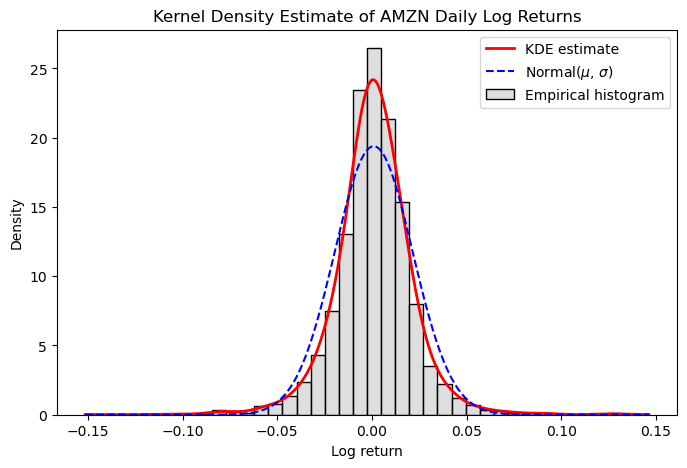

In [ ]:
returns = stock["log_ret"].values

# Fit KDE with Gaussian kernel
kde = gaussian_kde(returns, bw_method=0.3)
x = np.linspace(returns.min(), returns.max(), 300)

# Compare with normal distribution having same mean/std
mu, sigma = returns.mean(), returns.std()
normal_pdf = norm.pdf(x, mu, sigma)

plt.figure(figsize=(8,5))
sns.histplot(returns, bins=40, stat="density", color="lightgray", label="Empirical histogram")
plt.plot(x, kde(x), color="red", linewidth=2, label="KDE estimate")
plt.plot(x, normal_pdf, color="blue", linestyle="--", label="Normal($\mu$, $\sigma$)")
plt.title("Kernel Density Estimate of AMZN Daily Log Returns")
plt.xlabel("Log return")
plt.ylabel("Density")
plt.legend()
plt.show()


Using a Gaussian kernel, the empirical return distribution is estimated directly from observed data. The KDE curve (red) closely matches the empirical histogram but deviates from the normal distribution (blue dashed) by showing a sharper central peak and heavier tails.
This indicates leptokurtosis, extreme positive and negative returns occur more frequently than the Gaussian model predicts.

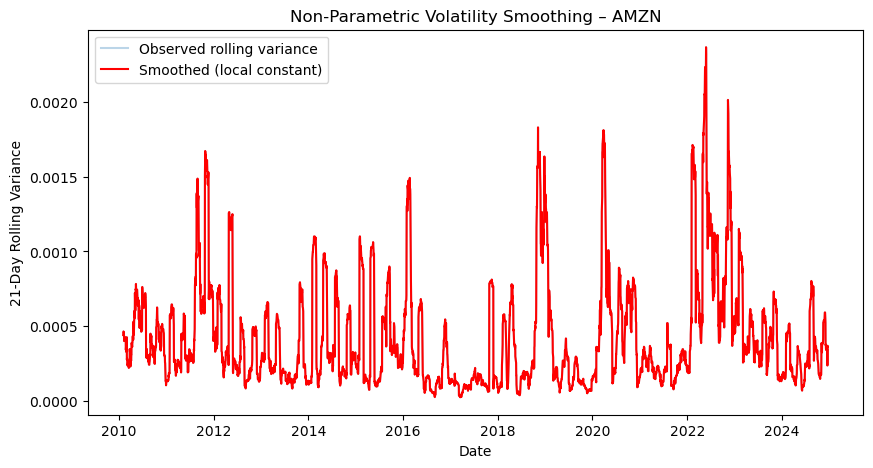

In [ ]:
# Compute rolling 21-day variance as volatility proxy
stock["volatility"] = stock["log_ret"].rolling(21).var()
stock.dropna(subset=["volatility"], inplace=True)

# Prepare time index
x = np.arange(len(stock))
y = stock["volatility"].values

# Fit local-constant regression (non-parametric smoothing)
kr = KernelReg(endog=[y], exog=[x], var_type='c')
y_pred, _ = kr.fit(x)

# Plot observed vs. smoothed volatility
plt.figure(figsize=(10,5))
plt.plot(stock["Date"], y, alpha=0.3, label="Observed rolling variance")
plt.plot(stock["Date"], y_pred, color="red", label="Smoothed (local constant)")
plt.title("Non-Parametric Volatility Smoothing – AMZN")
plt.xlabel("Date")
plt.ylabel("21-Day Rolling Variance")
plt.legend()
plt.show()


A 21-day rolling variance is smoothed with a local-constant (Nadaraya–Watson) regression. The resulting curve tracks persistent volatility clustering—extended periods of high or low variance—consistent with well-known stylized facts of financial time series.

In [19]:
# Convert to pandas Series for stats
returns_series = pd.Series(returns)
synthetic_series = pd.Series(synthetic_returns)

summary = pd.DataFrame({
    "Real": [
        returns_series.mean(),
        returns_series.std(),
        returns_series.min(),
        returns_series.max(),
        returns_series.skew(),
        returns_series.kurtosis()
    ],
    "Synthetic": [
        synthetic_series.mean(),
        synthetic_series.std(),
        synthetic_series.min(),
        synthetic_series.max(),
        synthetic_series.skew(),
        synthetic_series.kurtosis()
    ]
}, index=["Mean","Std Dev","Min","Max","Skew","Kurtosis"])

print(summary.round(4))


            Real  Synthetic
Mean      0.0009     0.0011
Std Dev   0.0206     0.0210
Min      -0.1514    -0.1136
Max       0.1462     0.1420
Skew      0.0115     0.0850
Kurtosis  5.9770     3.9198


Bandwidth selection strongly affects both KDE and regression smoothness.

Returns are weakly autocorrelated, so KDE assumes approximate IID behavior.

Despite these limits, the model captures non-linear dynamics and heavy-tailed risk without assuming parametric forms.

In [ ]:
def bootstrap_var_es(data, alpha=0.05, n_boot=1000):
    vars_, es_ = [], []
    n = len(data)
    for _ in range(n_boot):
        sample = npr.choice(data, size=n, replace=True)
        var = np.percentile(sample, 100 * alpha)
        es = sample[sample <= var].mean()
        vars_.append(var)
        es_.append(es)
    return np.mean(vars_), np.std(vars_), np.mean(es_), np.std(es_)

mean_var, sd_var, mean_es, sd_es = bootstrap_var_es(returns, alpha=0.05, n_boot=2000)

print(f"95% Value-at-Risk (VaR): {mean_var:.4f} ± {1.96*sd_var:.4f}")
print(f"95% Expected Shortfall (ES): {mean_es:.4f} ± {1.96*sd_es:.4f}")


95% Value-at-Risk (VaR): -0.0306 ± 0.0019
95% Expected Shortfall (ES): -0.0472 ± 0.0035
